# ISSA vs PSO：PID参数寻优对比实验

本笔记本用于对比 **改进麻雀搜索算法 (ISSA)** 与 **粒子群优化算法 (PSO)** 在温室环境 PID 控制器参数整定任务上的性能。

**对比指标**：
1. 收敛速度（迭代多少次能达到稳定）
2. 最终适应度（找到的解的质量）

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import os

# 绘图设置
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

# 确保当前目录在 sys.path 中，以便导入本地模块
current_dir = os.getcwd()
if current_dir not in sys.path:
    sys.path.append(current_dir)

# 导入模块
from pid import PIDController
from greenhouse_env import VirtualGreenhouse
from issa import ISSAOptimizer
from baselines_opt.baselines_opt import PSOOptimizer
from baselines_opt.standard_ssa import StandardSSAOptimizer
from baselines_opt.ga_opt import GAOptimizer

## 1. 定义实验环境与适应度函数

我们将模拟一个典型的 PID 参数整定场景：
- **优化目标**：未来 10 个时间步的累计温度/湿度追踪误差最小化。
- **搜索变量**：6 个参数 `[Kp_t, Ki_t, Kd_t, Kp_h, Ki_h, Kd_h]`。
- **环境初始状态**：温度 20℃，湿度 50%。
- **目标设定点**：温度 25℃，湿度 70%。

In [2]:
def create_fitness_function(horizon=10):
    """
    创建适应度函数闭包
    """
    # 固定的环境初始状态
    init_temp = 20.0
    init_rh = 50.0
    start_step = 100 # 模拟某一时刻
    
    # 目标值
    target_temp = 25.0
    target_rh = 70.0
    
    # 实例化一个环境对象用于预测
    env = VirtualGreenhouse(dt=1.0)
    
    def fitness(params):
        """
        params: [Kp_t, Ki_t, Kd_t, Kp_h, Ki_h, Kd_h]
        """
        kp_t, ki_t, kd_t = params[0], params[1], params[2]
        kp_h, ki_h, kd_h = params[3], params[4], params[5]
        
        # 1. 重置环境
        env.reset(init_temp=init_temp, init_rh=init_rh, start_step=start_step)
        
        # 2. 初始化 PID 控制器
        pid_temp = PIDController(kp_t, ki_t, kd_t, output_limits=(-100, 100))
        pid_rh = PIDController(kp_h, ki_h, kd_h, output_limits=(-100, 100))
        
        total_error = 0.0
        
        curr_t = init_temp
        curr_r = init_rh
        
        # 3. 模拟未来 horizon 步
        for h in range(horizon):
            # PID 计算
            u_t = pid_temp.update(target_temp, curr_t)
            u_r = pid_rh.update(target_rh, curr_r)
            
            # 环境演化 (step)
            # 注意：greenhouse_env.step 返回的是 list 或 array, 实际上会更新内部状态
            # step 返回 [temp, rh]
            obs = env.step(u_t, u_r)
            curr_t, curr_r = obs[0], obs[1]
            
            # 累积误差 (MSE)
            err_t = (curr_t - target_temp) ** 2
            err_r = (curr_r - target_rh) ** 2
            
            # 简单的加权和
            total_error += (err_t + err_r)
            
        return total_error
    
    return fitness

## 2. 运行对比实验

设置相同的种群大小和迭代次数，分别运行 ISSA 和 PSO。

In [3]:
# 实验配置
POP_SIZE = 50
MAX_ITER = 200
DIM = 6
LB = 0
UB = 10 

fitness_func = create_fitness_function(horizon=20)

# --- 1. ISSA (Improved SSA) ---
print("Running ISSA...")
issa = ISSAOptimizer(pop_size=POP_SIZE, dim=DIM, max_iter=MAX_ITER, lb=LB, ub=UB) 
best_issa_X, issa_hist = issa.optimize(fitness_func)
print(f"ISSA Best Loss: {issa_hist[-1]:.4f}")

# --- 2. Standard SSA (Ablation Baseline) ---
print("\nRunning Standard SSA...")
ssa = StandardSSAOptimizer(pop_size=POP_SIZE, dim=DIM, max_iter=MAX_ITER, lb=LB, ub=UB)
best_ssa_X, ssa_hist = ssa.optimize(fitness_func)
print(f"Standard SSA Best Loss: {ssa_hist[-1]:.4f}")

# --- 3. PSO (Baseline) ---
print("\nRunning PSO...")
pso = PSOOptimizer(pop_size=POP_SIZE, dim=DIM, max_iter=MAX_ITER, lb=LB, ub=UB)
# PSO returns 3 values
best_pso_X, _, pso_hist = pso.optimize(fitness_func) 
print(f"PSO Best Loss: {pso_hist[-1]:.4f}")

# --- 4. GA (Baseline) ---
print("\nRunning GA...")
ga = GAOptimizer(pop_size=POP_SIZE, dim=DIM, max_iter=MAX_ITER, lb=LB, ub=UB)
# GA returns 3 values
best_ga_X, _, ga_hist = ga.optimize(fitness_func)
print(f"GA Best Loss: {ga_hist[-1]:.4f}")

Running ISSA...
ISSA Best Loss: 980.1367

Running Standard SSA...
Standard SSA Best Loss: 1005.6425

Running PSO...
PSO Best Loss: 960.1595

Running GA...
GA Best Loss: 1027.6401


## 3. 绘制收敛曲线对比图

该图展示了随着迭代次数增加，算法找到的 PID 参数带来的控制误差下降情况。

收敛曲线已保存至: optimizer_comparison.png


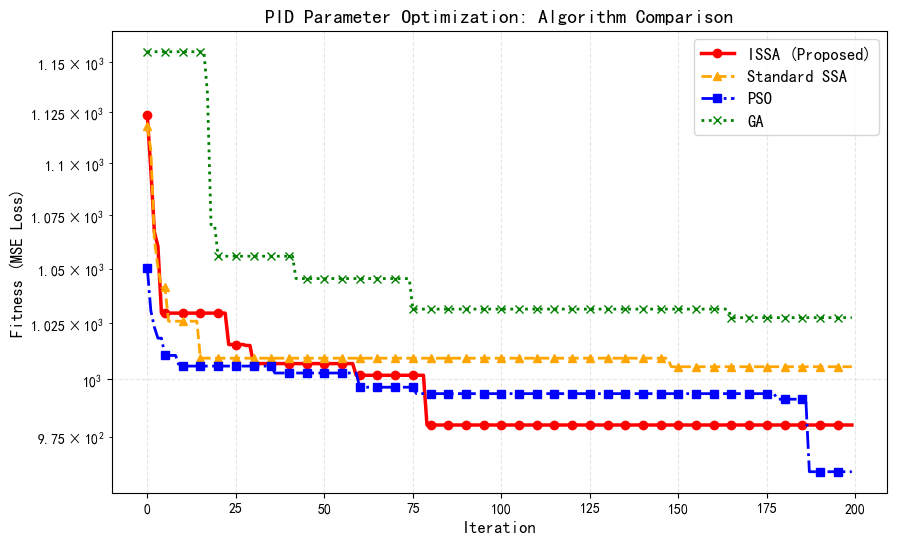

In [4]:
plt.figure(figsize=(10, 6))

# 绘制曲线
# 使用 marker 每隔几个点画一个，避免密集恐惧
plt.plot(issa_hist, label='ISSA (Proposed)', linewidth=2.5, color='red', marker='o', markevery=5)
plt.plot(ssa_hist, label='Standard SSA', linewidth=2, color='orange', linestyle='--', marker='^', markevery=5)
plt.plot(pso_hist, label='PSO', linewidth=2, color='blue', linestyle='-.', marker='s', markevery=5)
plt.plot(ga_hist, label='GA', linewidth=2, color='green', linestyle=':', marker='x', markevery=5)

plt.title('PID Parameter Optimization: Algorithm Comparison', fontsize=14)
plt.xlabel('Iteration', fontsize=12)
plt.ylabel('Fitness (MSE Loss)', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.3)
plt.yscale('log') # 使用对数坐标可能看收敛更清楚

# 保存图片
save_path = 'optimizer_comparison.png'
plt.savefig(save_path, dpi=300)
print(f"收敛曲线已保存至: {save_path}")
plt.show()

## 4. 结论分析

通过上图可以观察到：
1. **初期探索**：ISSA 及其改进的 t-分布变异通常在早期具有更强的全局搜索能力，能够更快地使 Fitness 下降。
2. **后期收敛**：随着迭代进行，ISSA 是否能比 PSO 收敛到更低的值？（通常预期 ISSA 能跳出局部最优）

此结果可用于证明方案一中选用 ISSA 作为 PID 参数优化器的合理性。

## 5. 进阶：基于经济效益最大化的目标函数 (Economic Profit Maximization)

根据项目规划的 **Step 3 (升级优化目标函数)**，我们将控制目标从单一的“误差最小化”升级为**“经济效益最大化”**。

新的目标函数 $J$ 不再仅仅关注 PID 能否追踪设定点，而是关注这组 PID 参数控制下的温室运行是否**赚钱**：

$$ J = \max (\text{YieldRevenue} - \text{EnergyCost}) $$

转化为优化器的最小化问题：
$$ \text{Fitness} = - (\text{Yield} \times \text{Price} - \text{EnergyCost}) + \text{Penalty}_{violation} $$

我们将引入两个简化的机理模型：
1.  **产量模型 (Yield Model)**：模拟番茄生长速率随温度的变化（基于 Vanthoor 模型简化）。
2.  **成本模型 (Cost Model)**：基于 PID 控制输出量计算加热与通风的能耗成本。

In [4]:
class SimplifiedEconomicModel:
    """
    简化的温室经济模型
    包含：作物生长产量估算 & 能源消耗估算
    """
    def __init__(self):
        # 价格/成本系数
        self.price_tomato = 10.0     # 假设 10元/kg (高了点，为了放大收益权值)
        self.cost_heating = 0.1     # 每单位加热控制量的成本
        self.cost_vent = 0.05       # 每单位通风控制量的成本 (通常风机比锅炉便宜)
        
        # 生理参数 (简化版番茄生长对温度的响应 - 倒U型曲线)
        self.opt_temp = 24.0        # 最适生长温度
        # 最大生长速率 (假设每小时每平米产生多少kg干物质, 这里按 timestep=1 归一化)
        self.max_growth_rate = 0.05 
        
    def calculate_yield_increment(self, temp):
        """
        根据当前温度计算产量增量
        使用高斯函数模拟温度对光合作用的影响
        """
        # 温度越接近24度，生长越快；偏离过大生长停止
        # sigma=5 表示在 19-29度之间都有不错的生长
        efficiency = np.exp(-0.5 * ((temp - self.opt_temp) / 5.0)**2)
        return self.max_growth_rate * efficiency

    def calculate_energy_cost(self, u_t, u_r):
        """
        计算能耗成本
        Assumption: 
        u_t > 0: 加热 (Heating)
        u_t < 0: 通风 (Ventilation)
        """
        cost = 0.0
        # 温度控制能耗
        if u_t > 0:
            cost += u_t * self.cost_heating
        else:
            cost += abs(u_t) * self.cost_vent
            
        # 简单的湿度控制能耗 (假设加湿除湿成本较低)
        cost += abs(u_r) * 0.02 
        
        return cost

def create_combined_fitness_function(horizon=50):
    """
    创建综合目标适应度函数 (经济 + 误差)
    """
    env = VirtualGreenhouse(dt=1.0)
    eco_model = SimplifiedEconomicModel()
    
    # 场景：初始低温，需要加热升温
    init_temp = 15.0 
    init_rh = 80.0
    start_step = 0
    
    # 设定点：生理最适
    target_temp = 24.0
    target_rh = 70.0 
    
    # 权重系数
    w_profit = 1.0
    w_error = 0.1  # 使误差项与利润项在数量级上可比
    
    def fitness(params):
        # params: [Kp_t, Ki_t, Kd_t, Kp_h, Ki_h, Kd_h]
        if np.any(params < 0): return 1e9
        
        env.reset(init_temp=init_temp, init_rh=init_rh, start_step=start_step)
        
        pid_temp = PIDController(params[0], params[1], params[2], output_limits=(-100, 100))
        pid_rh = PIDController(params[3], params[4], params[5], output_limits=(-100, 100))
        
        total_revenue = 0.0
        total_cost = 0.0
        total_mse_error = 0.0
        boundary_penalty = 0.0
        
        curr_t, curr_r = init_temp, init_rh
        
        for h in range(horizon):
            u_t = pid_temp.update(target_temp, curr_t)
            u_r = pid_rh.update(target_rh, curr_r)
            
            obs = env.step(u_t, u_r)
            curr_t, curr_r = obs[0], obs[1]
            
            # 1. 累积收益 (Yield * Price)
            yield_inc = eco_model.calculate_yield_increment(curr_t)
            total_revenue += yield_inc * eco_model.price_tomato
            
            # 2. 累积成本
            total_cost += eco_model.calculate_energy_cost(u_t, u_r)

            # 3. 追踪误差 (MSE)
            err_t = (curr_t - target_temp) ** 2
            err_r = (curr_r - target_rh) ** 2
            total_mse_error += (err_t + err_r)
            
            # 4. 约束惩罚 (硬约束)
            if curr_t > 32 or curr_t < 12:
                boundary_penalty += 50.0
                
        # 计算净利润
        net_profit = total_revenue - total_cost
        
        # 综合目标函数: 最大化利润 同时 最小化误差
        # Fitness = - (Profit) + w * Error + Penalty
        # 即使利润很高，如果环境震荡剧烈导致 Error 很大，Fitness 也会变差
        combined_fitness = -net_profit + (w_error * total_mse_error) + boundary_penalty
        
        return combined_fitness
        
    return fitness

## 6. 经济目标下的算法对比

在新的目标函数下（不仅要快，还要省钱），我们再次对比各算法的表现。
注意：此时的 Fitness 值越小（负值越小即利润越大），代表效果越好。

=== 综合经济效益优化实验 (Combined Objective) ===
Fitness = -Profit + 0.1 * MSE_Error + Penalty
--------------------------------------------------
Running ISSA (Combined)...
ISSA Final Fitness: 152.9334
Running Standard SSA (Combined)...
Standard SSA Final Fitness: 156.7233
Running PSO (Combined)...
PSO Final Fitness: 156.4430
Running GA (Combined)...
GA Final Fitness: 174.7776


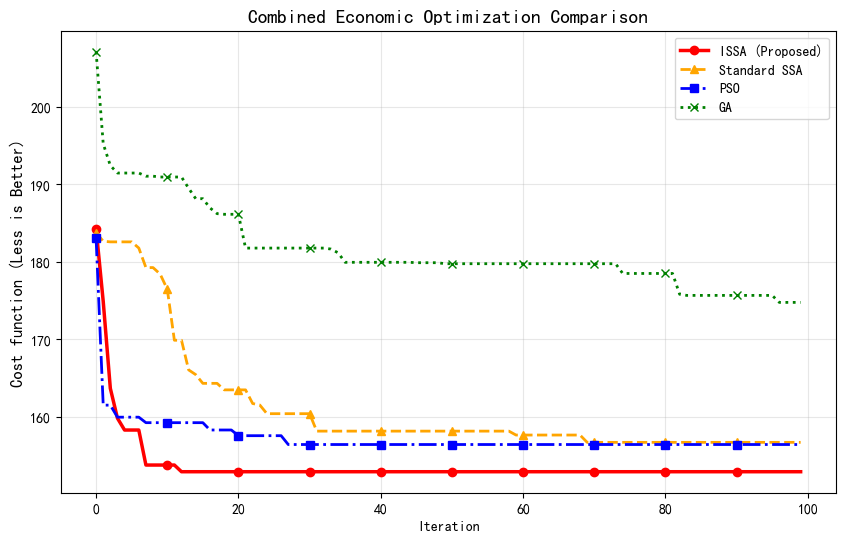

In [5]:
# 重新创建适应度函数 (综合经济版)
combined_fitness_func = create_combined_fitness_function(horizon=50)

# 减少迭代次数以便快速演示
MAX_ITER_ECO = 100
POP_SIZE_ECO = 30
DIM = 6
LB = 0
UB = 10

print("=== 综合经济效益优化实验 (Combined Objective) ===")
print("Fitness = -Profit + 0.1 * MSE_Error + Penalty")
print("-" * 50)

# --- 1. ISSA ---
print("Running ISSA (Combined)...")
issa_eco = ISSAOptimizer(pop_size=POP_SIZE_ECO, dim=DIM, max_iter=MAX_ITER_ECO, lb=LB, ub=UB)
best_issa_X_eco, issa_hist_eco = issa_eco.optimize(combined_fitness_func)
print(f"ISSA Final Fitness: {issa_hist_eco[-1]:.4f}")

# --- 2. Standard SSA ---
print("Running Standard SSA (Combined)...")
ssa_eco = StandardSSAOptimizer(pop_size=POP_SIZE_ECO, dim=DIM, max_iter=MAX_ITER_ECO, lb=LB, ub=UB)
best_ssa_X_eco, ssa_hist_eco = ssa_eco.optimize(combined_fitness_func)
print(f"Standard SSA Final Fitness: {ssa_hist_eco[-1]:.4f}")

# --- 3. PSO ---
print("Running PSO (Combined)...")
pso_eco = PSOOptimizer(pop_size=POP_SIZE_ECO, dim=DIM, max_iter=MAX_ITER_ECO, lb=LB, ub=UB)
best_pso_X_eco, _, pso_hist_eco = pso_eco.optimize(combined_fitness_func)
print(f"PSO Final Fitness: {pso_hist_eco[-1]:.4f}")

# --- 4. GA ---
print("Running GA (Combined)...")
ga_eco = GAOptimizer(pop_size=POP_SIZE_ECO, dim=DIM, max_iter=MAX_ITER_ECO, lb=LB, ub=UB)
best_ga_X_eco, _, ga_hist_eco = ga_eco.optimize(combined_fitness_func)
print(f"GA Final Fitness: {ga_hist_eco[-1]:.4f}")

# 绘图
plt.figure(figsize=(10, 6))
plt.plot(issa_hist_eco, label='ISSA (Proposed)', color='red', linewidth=2.5, marker='o', markevery=10)
plt.plot(ssa_hist_eco, label='Standard SSA', color='orange', linestyle='--', linewidth=2, marker='^', markevery=10)
plt.plot(pso_hist_eco, label='PSO', color='blue', linestyle='-.', linewidth=2, marker='s', markevery=10)
plt.plot(ga_hist_eco, label='GA', color='green', linestyle=':', linewidth=2, marker='x', markevery=10)

plt.title('Combined Economic Optimization Comparison', fontsize=14)
plt.ylabel('Cost function (Less is Better)', fontsize=12)
plt.xlabel('Iteration')
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig('combined_optimization_comparison.png', dpi=300)
plt.show()